# Import package and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import shap
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [35]:
current_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(current_dir, ".."))
DATA_PATH = f"{project_dir}/data/"
data = pd.read_csv(DATA_PATH+"data.csv", sep=",", encoding="iso-8859-1")

label_1 = "SiteEnergyUse(kBtu)"
label_2 = "TotalGHGEmissions"

# Choix des features

In [36]:
features = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'Neighborhood',  'Building_age','NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
       'TotalGHGEmissions','SourceEUI(kBtu/sf)',
       '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']
df = data[features]

In [37]:
df.head()

,BuildingType,PrimaryPropertyType,ZipCode,Neighborhood,Building_age,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,%_LargestPropertyUseType,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SourceEUI(kBtu/sf),%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes
0,NonResidential,Hotel,98101.0,DOWNTOWN,89,1.0,12,88434,Hotel,88434.0,1.000000,7226362.5,2003882.00,3946027.0,1276453.0,249.98,182.500000,0.000000,1.000000,1
1,NonResidential,Hotel,98101.0,DOWNTOWN,20,1.0,11,103566,Hotel,83880.0,0.809918,8387933.0,0.00,3242851.0,5145082.0,295.86,176.100006,0.145453,0.854547,3
2,NonResidential,Hotel,98101.0,DOWNTOWN,90,1.0,10,61320,Hotel,61320.0,1.000000,6794584.0,2214446.25,2768924.0,1811213.0,286.43,216.199997,0.000000,1.000000,1
3,NonResidential,Hotel,98121.0,DOWNTOWN,36,1.0,18,175580,Hotel,123445.0,0.703070,14172606.0,0.00,5368607.0,8803998.0,505.01,211.399994,0.353115,0.646885,3
4,NonResidential,Hotel,98101.0,DOWNTOWN,90,1.0,11,83008,Hotel,81352.0,0.980050,5758795.0,0.00,2811215.0,2947580.0,176.14,146.600006,0.000000,1.000000,1


## Categorical features

In [5]:
df.BuildingType.nunique(), df.PrimaryPropertyType.nunique(), df.ZipCode.nunique(), df.Neighborhood.nunique(), df.LargestPropertyUseType.nunique()

(4, 16, 38, 18, 19)

In [6]:
def pipe_ohe(df):
    
    #### encoder la colonne LargestPropertyUseType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded = pd.get_dummies(df['LargestPropertyUseType'], prefix='LargestPropertyUseType')
    df = pd.concat([df, onehot_encoded], axis=1)
    df.drop('LargestPropertyUseType', axis=1, inplace=True)
    
    #### encoder la colonne BuildingType ###
    # Ajouter les colonnes encodées au dataframe d'origine
    # Supprimer la colonne originale
    onehot_encoded_BuildingType = pd.get_dummies(df['BuildingType'], prefix='BuildingType')
    df = pd.concat([df, onehot_encoded_BuildingType], axis=1)
    df.drop('BuildingType', axis=1, inplace=True)
    
    ### Remplacer les valeurs 1/0 de LargestPropertyUseType_ par leur % de la surface totale
    # Liste des colonnes à remplacer
    # Boucle pour remplacer les valeurs dans chaque colonne
    cols_to_replace = list(df.filter(like="LargestPropertyUseType_").columns)
    for col in cols_to_replace:
        df[col] = df.apply(lambda row: row["%_LargestPropertyUseType"] if row[col] == 1 else 0, axis=1)    
    df.drop(columns=["%_LargestPropertyUseType"], inplace=True)
    
    return df

In [7]:
def pipe(df, means_zipcode=None, 
                means_neighborhood=None,
                means_ppropertype=None, 
                col_for_mean="PropertyGFATotal", 
                scaler=None,
                label_1=label_1,
                label_2=label_2):
    #### encoder la colonne ZipCode ###
    # encoding ZipCode with mean encoding and TotalGHGEmissions #
    # Calculer la moyenne de la colonne cible (label2) pour chaque code postal
    # Encoder la colonne code postal en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    mean_encoding_nan = df[col_for_mean].mean()
    if means_zipcode is None:
        means_zipcode = df.groupby('ZipCode')[col_for_mean].mean()
    df['Code_postal_encoded'] = df['ZipCode'].map(means_zipcode)
    df.drop(columns=['ZipCode'],inplace=True)
    df['Code_postal_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    ### encoder la colonne Neighborhood ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque quartier
    # Encoder la colonne quartier en fonction de la moyenne de la colonne cible
    # Supprimer la colonne originale
    if means_neighborhood is None:
        means_neighborhood = df.groupby('Neighborhood')[col_for_mean].mean()
    df['neighborhood_encoded'] = df['Neighborhood'].map(means_neighborhood)
    df.drop(columns=['Neighborhood'],inplace=True)
    df['neighborhood_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    
    ### encoder la colonne PrimaryPropertyType with mean encoding  ###
    # Calculer la moyenne de la colonne cible (label2) pour chaque PrimaryPropertyType
    # Encoder la colonne PrimaryPropertyType en fonction de la moyenne de la colonne cible
    # Supprimer la colonne catégorielle
    if means_ppropertype is None:
        means_ppropertype = df.groupby('PrimaryPropertyType')[col_for_mean].mean()
    df['PrimaryPropertyType_encoded'] = df['PrimaryPropertyType'].map(means_ppropertype)
    df.drop(columns=['PrimaryPropertyType'],inplace=True)
    df['PrimaryPropertyType_encoded'].fillna(mean_encoding_nan, inplace=True)
    
    #supprimer les labels du jeu de données
    df = df.drop(columns=[label_1,label_2])
    df.drop(columns=['SourceEUI(kBtu/sf)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)
    
    #scaler
    # if scaler is None:
    #     scaler=StandardScaler()
    #     df_scaled = scaler.fit_transform(df)
    #     print("check scaler standard scaler")
    # else:
    #     df_scaled = scaler.transform(df)
    #     print("check scaler the train scaler")
    
    return df, means_zipcode, means_neighborhood, means_ppropertype, df.columns

In [8]:
X = pipe_ohe(df)
y1 = df[[label_1]]
y2 = df[[label_2]]

# séparer la donnée pour avoir les 
X_ghge_train, X_ghge_test, y_ghe_train, y_ghe_test = train_test_split(X,y2,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_ghge_train.shape, X_ghge_test.shape)

index_X_ghge_test = X_ghge_test.index
df_ghe_selection = df.loc[index_X_ghge_test]

X_ghe_train, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe = pipe(X_ghge_train,col_for_mean=label_2)
X_ghe_test, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b = pipe(X_ghge_test, 
                                                                        means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2)

print(X_ghe_train.shape, X_ghe_test.shape)

(800, 40) (142, 40)
(800, 40) (142, 40)
(800, 35) (142, 35)
(800, 35) (142, 35)


## Modèles

###  Results functions

In [9]:
def results_printed(model):
    # Best score                     
    print(f"Best score : {model.best_score_}")
    
    # Best Params
    print(f"Best params :\n {model.best_params_}")

In [10]:
metrics_df_nrg = pd.DataFrame(columns=["label","modèle","r2_train","r2_test","mae","rmse","mean_fit_time","best_params"])
metrics_df_ghe = pd.DataFrame(columns=["label","modèle","r2_train","r2_test","mae","rmse","mean_fit_time","best_params"])

def add_metrics_table(label,y_pred,y_test,df,model, X_train, y_train):
    # Accéder au nom du modèle
    best_model = model.best_estimator_
    model_name = best_model.steps[1][0]
    
    r2_train = round(model.score(X_train, y_train,),4)
    r2_test = round(r2_score(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = round(mean_squared_error(y_test, y_pred), 4)
    df = df.append({
    "label": label,
    "modèle": model_name,
    "r2_train":'{:.3f}'.format(r2_train),
    "r2_test": '{:.3f}'.format(r2_test),
    "mae": '{:.3f}'.format(mae),
    "rmse": '{:.3f}'.format(rmse),
    "mean_fit_time": model.cv_results_['mean_fit_time'].mean(),
    "best_params": model.best_params_
    }, ignore_index=True)
    return df

scoring = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

def evaluate_prediction(label, X_test, y_test, metrics_df, model, X_train, y_train):
    y_pred = model.predict(X_test)

    metrics_df = add_metrics_table(label, y_pred, y_test, metrics_df, model, X_train, y_train)

    # Créer le scatter plot
    plt.scatter(y_pred, y_test)

    # Ajouter une ligne diagonale pour représenter la ligne de prédiction parfaite
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    # Ajouter des labels pour les axes et le titre du plot
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Comparaison des prédictions et des valeurs réelles')

    # Afficher le plot
    plt.show()
    display(metrics_df)
    return metrics_df, y_pred

In [11]:
def hist_errors(y_test, y_pred):
    y_test = np.array(y_test).reshape(-1,)
    diff = y_test - y_pred
    mean = diff.mean()
    std = diff.std()
    plt.hist(diff, bins=40)
    plt.vlines(mean, 0, 30, color='red', label=f'mean = {mean:.2f}')
    plt.hlines(30, mean - 1/2 * std, mean + 1/2 * std, color='red', label=f'std = {std:.2f}', ls='dotted')
    plt.title('Histogram of prediction errors')
    plt.xlabel('prediction error')
    plt.ylabel('Frequency')
    
    # Showing the legend
    plt.legend(loc='upper right')
    plt.show()

In [12]:
def show_fetures_coef(model, columns):
    
    # Après l'exécution de la recherche de grille
    best_model = model.best_estimator_

    # Accéder au nom du modèle
    model_name = best_model.steps[1][0]
    
    # Accéder aux coefficients du modèle
    coef = best_model.named_steps[model_name].coef_

    if coef.ndim == 2 and coef.shape[0] == 1:
        coef = coef[0]
    features_coef = pd.DataFrame(coef.reshape(1,-1), columns=list(columns))
    columns = list(reversed(features_coef.columns))
    coef = list(reversed(coef))
    
    
    plt.figure(figsize=(14,8))
    # Créer un graphique à barres horizontales
    plt.barh(columns, coef)

    # Récupérer les étiquettes de l'axe des abscisses
    labels = plt.gca().get_yticklabels()

    # Parcourir les étiquettes et appliquer un style différent aux étiquettes non nulles
    for label, value in zip(labels, coef):
        if value != -0:
            label.set_color('red')  # Appliquer une couleur rouge aux étiquettes non nulles
        else:
            label.set_color('black')  # Appliquer une couleur noire aux étiquettes nulles

    plt.show()

In [13]:
def error_per_category(df, y_test, y_pred, feature):
    df["error_pred"] = (np.array(y_test).reshape(-1,) - y_pred)
    df_grouped = df.groupby(feature).mean()['error_pred']
    counts = df[feature].value_counts()

    # Créer le graphique montrant la moyenne des erreurs et le nombre d'occurrences
    fig, ax = plt.subplots()

    # Afficher les barres de la moyenne des erreurs
    ax.bar(df_grouped.index, df_grouped.values)

    # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
    for i, v in enumerate(df_grouped.values):
        ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

    # Ajouter une légende
    ax.text(0.05, -0.2, f'{counts[df_grouped.index[i]]}:Nombre d\'occurrences dans le jeu de test', transform=ax.transAxes)

    ax.set_xlabel(feature)
    ax.set_ylabel('Moyenne des erreurs')

    # Changer la taille de la figure
    fig.set_size_inches(8, 4)
    
    # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
    ax.margins(y=0.1)
    
    plt.show()

In [14]:
def error_all_category(df, y_test, y_pred, features):
    # Créer une figure avec des subplots
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)), gridspec_kw={'hspace': 0.6})
    axs[0].set_ylabel('Moyenne des erreurs')

    # Boucle sur les features
    for i, feature in enumerate(features):
        # Récupérer l'axe courant
        ax = axs[i]

        # Calculer les erreurs moyennes pour chaque catégorie
        df["error_pred"] = abs((np.array(y_test).reshape(-1,) - y_pred))
        df_grouped = df.groupby(feature).mean()['error_pred']
        counts = df_nrg_selection[feature].value_counts()

        # Afficher les barres de la moyenne des erreurs
        ax.bar(df_grouped.index, df_grouped.values)

        # Ajouter le nombre d'occurrences sur les barres de la moyenne des erreurs
        for i, v in enumerate(df_grouped.values):
            ax.text(i, v, str(counts[df_grouped.index[i]]), ha='center', va='bottom')

        # Ajouter un titre pour chaque subplot
        ax.set_title(feature)

        # Ajouter un espace supplémentaire de 10% au-dessus et en dessous des barres du graphique
        ax.margins(y=0.1)
        
        # Ajouter des étiquettes d'axe plus petites et penchées
        ax.set_xticklabels(df_grouped.index, rotation=45, fontsize=7)

    # Ajouter un titre pour le graphique global
    fig.suptitle('Erreurs en fonction des variables catégorielles', y=0.95, fontsize=16)

    # Afficher le graphique
    plt.show()


In [15]:
def error_all_discr_category(df, y_test, y_pred, features):
    # Créer une figure avec des subplots
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)), gridspec_kw={'hspace': 0.3})

    # Calculer les erreurs moyennes pour chaque catégorie
    df["error_pred"] = abs((np.array(y_test).reshape(-1,) - y_pred))
        
    # Boucle sur les features
    for i, feature in enumerate(features):
        # Récupérer l'axe courant
        ax = axs[i]

        ax.scatter(df[feature], df['error_pred'], label=feature)

        # Ajouter un titre pour chaque subplot
        ax.set_title(feature)

    # Ajouter un titre pour le graphique global
    fig.suptitle('Erreurs en fonction des variables discrètes', y=0.92, fontsize=16)

    # Afficher le graphique
    plt.show()


### Pipeline with a scaler

In [16]:
# Définir les normalizers à tester
scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('MaxAbsScaler', MaxAbsScaler())
]

In [17]:
cat_features_next = ['BuildingType',
'PrimaryPropertyType',
'Neighborhood',
'LargestPropertyUseType']

disc_col_viz = ["Building_age",
                "%_GFAParking","%_GFABuilding",
                "LargestPropertyUseTypeGFA","NumberofBuildings",
                "NumberofFloors"]

## Label 2 - GHE

### Dummy Regression

In [18]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dummy_regr', DummyRegressor())
])
parameters = {"dummy_regr__strategy" : ("mean","median"),
            "scaler": [scaler for _, scaler in scalers]}

grid_dummy_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dummy_ghe.fit(X_ghe_train, y_ghe_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dummy_regr', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'dummy_regr__strategy': ('mean', 'median'),
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    MaxAbsScaler()]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

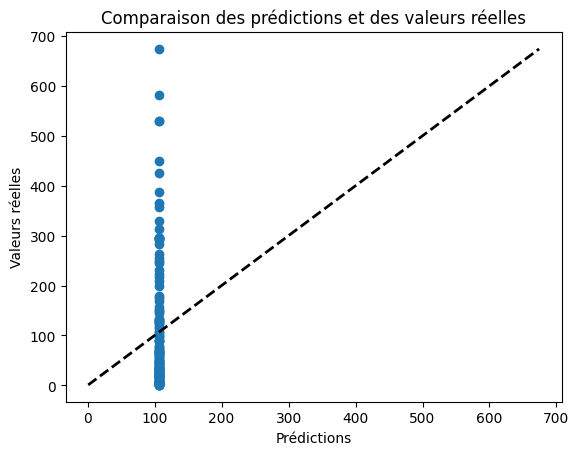

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."


In [19]:
metrics_df_ghe, y_pred_dummy_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_dummy_ghe, X_ghe_train, y_ghe_train)

### Linear Regression

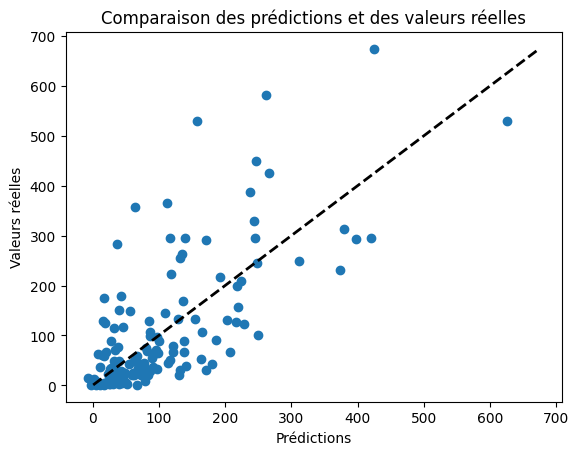

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."


In [20]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

parameters = {'reg__fit_intercept': [True, False],
            "scaler": [scaler for _, scaler in scalers]}

grid_reglin_ghe = GridSearchCV(pipeline,
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_reglin_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_reg_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_reglin_ghe, X_ghe_train, y_ghe_train)

### Lasso Regression

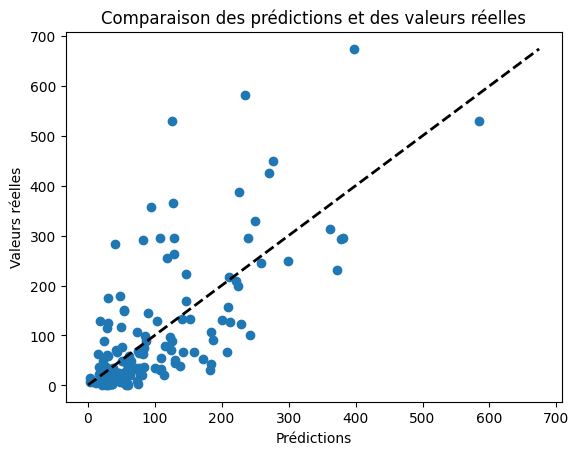

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."


In [21]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# Checking for alpha from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-4, 2, 15)

# Set the parameters  
parameters = {"lasso__alpha" : alpha_space,
            "scaler": [scaler for _, scaler in scalers]}

grid_lasso_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_lasso_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_lasso_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_lasso_ghe, X_ghe_train, y_ghe_train)

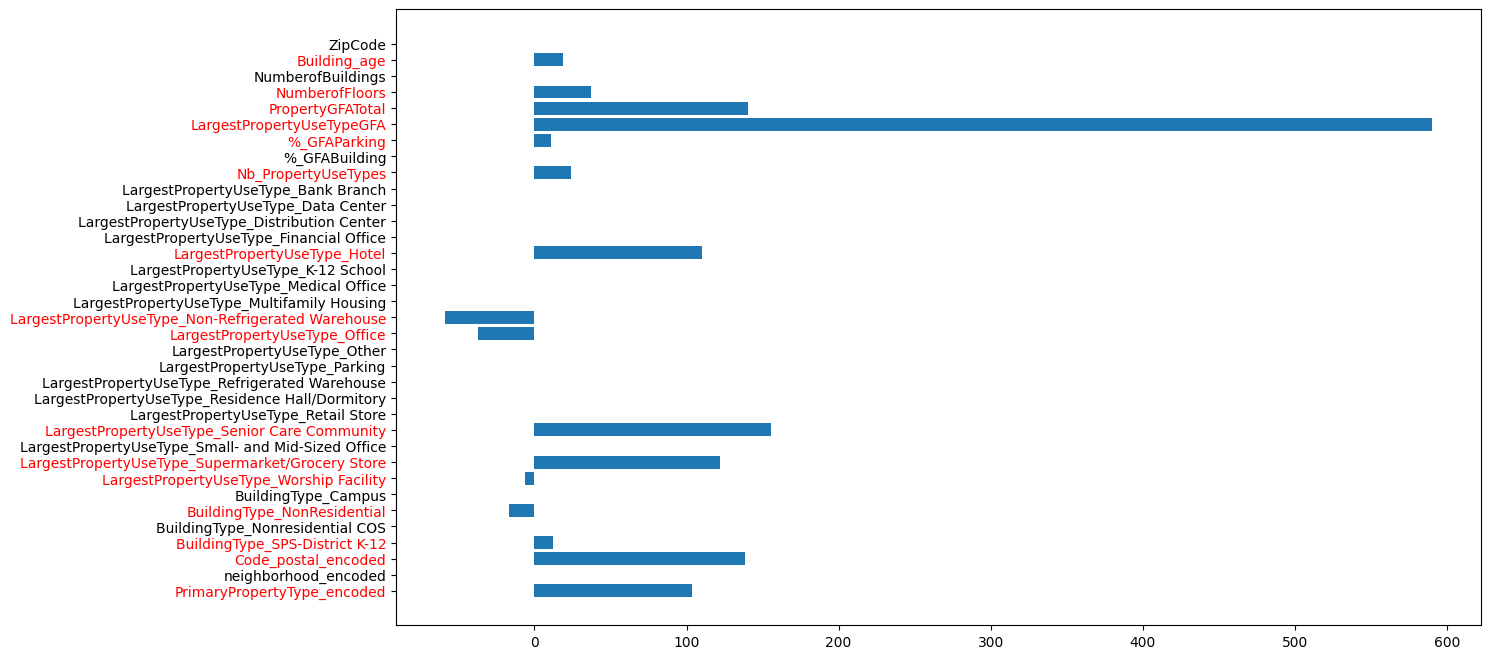

In [22]:
show_fetures_coef(grid_lasso_ghe, columns_ghe)

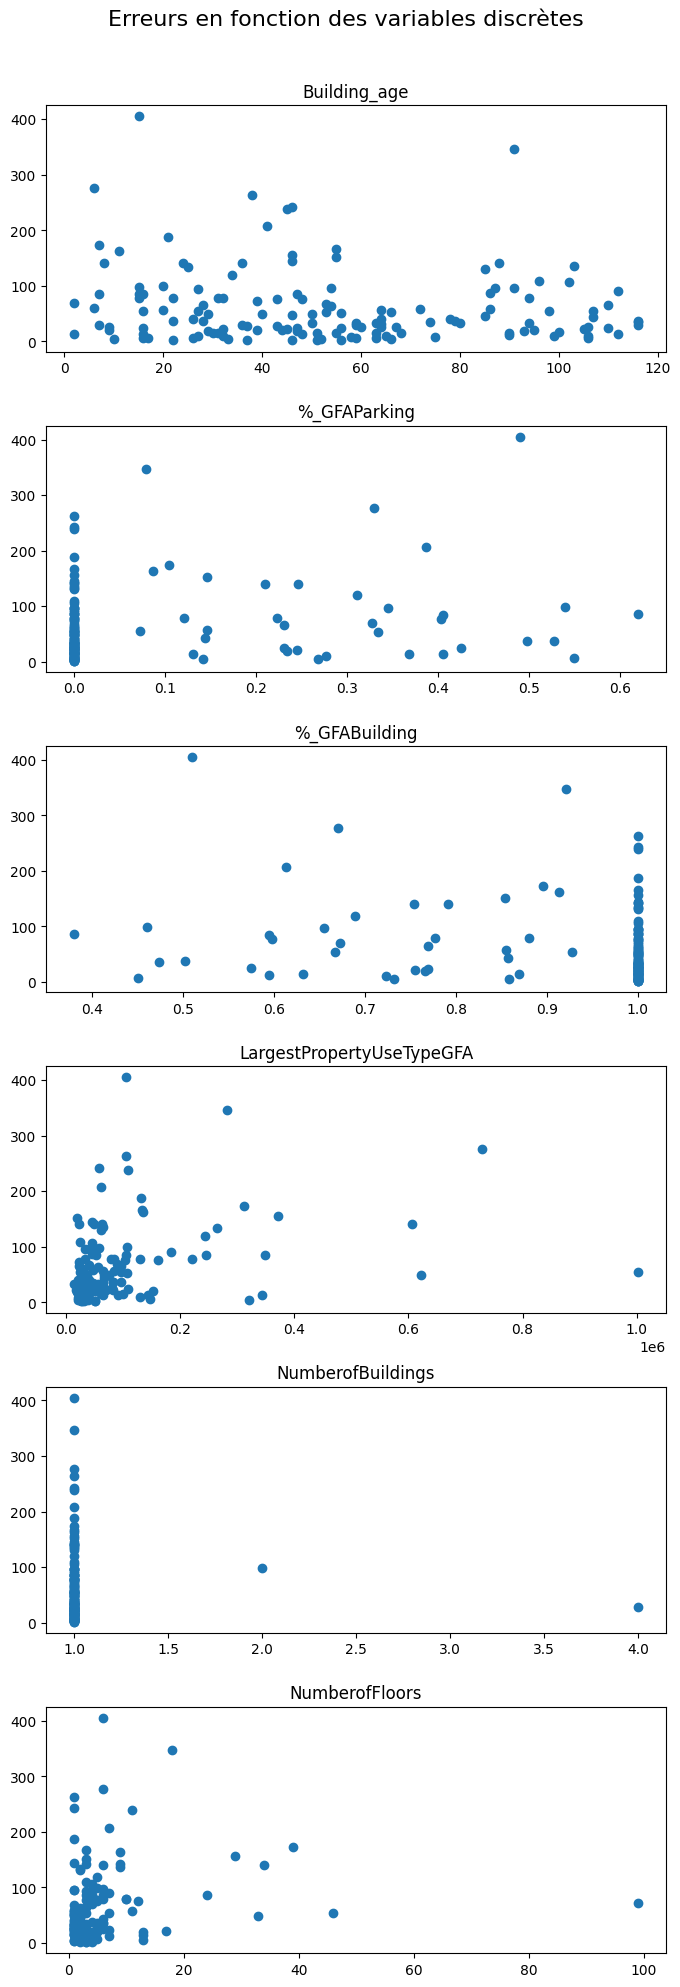

In [62]:
error_all_discr_category(df_ghe_selection, y_ghe_test, y_pred_lasso_ghe, disc_col_viz)

Permutation explainer:  39%|███▊      | 55/142 [2:08:23<5:19:07, 220.09s/it]


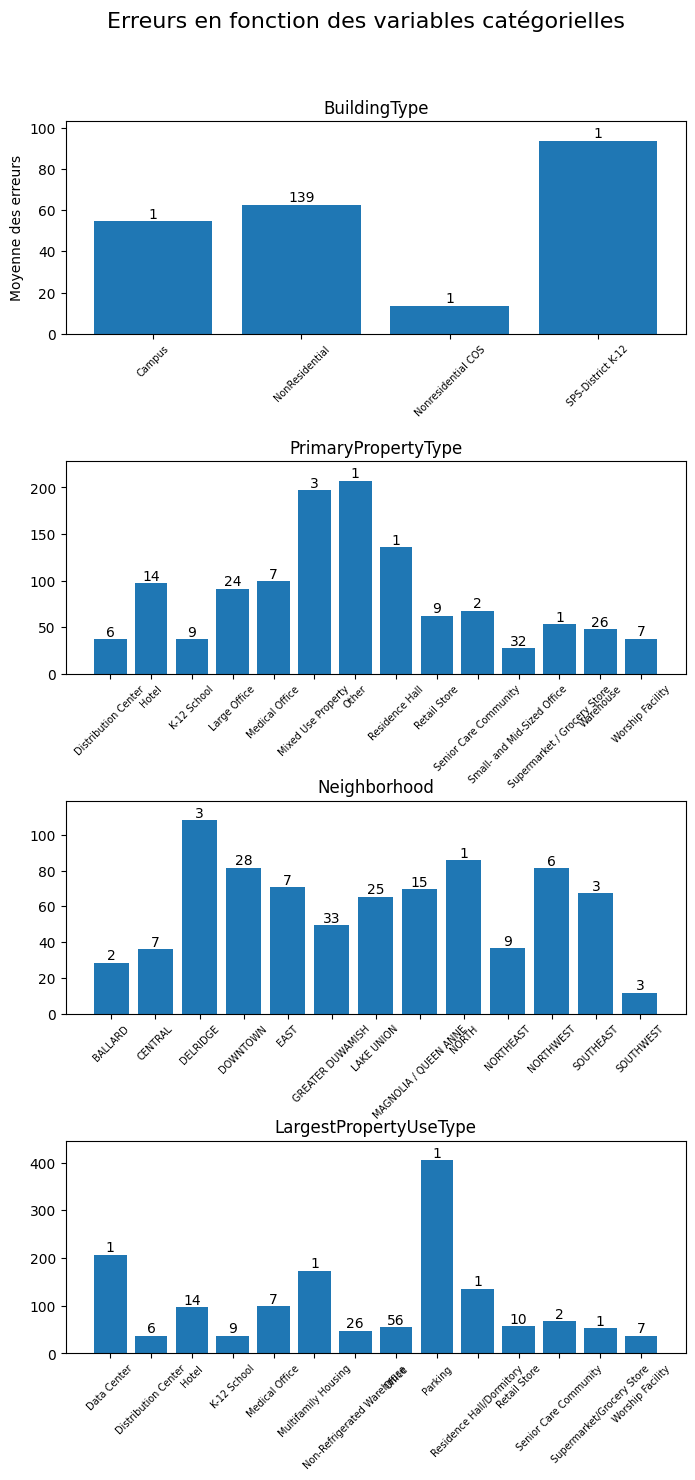

In [63]:
error_all_category(df_ghe_selection, y_ghe_test, y_pred_lasso_ghe, cat_features_next)

### Ridge 

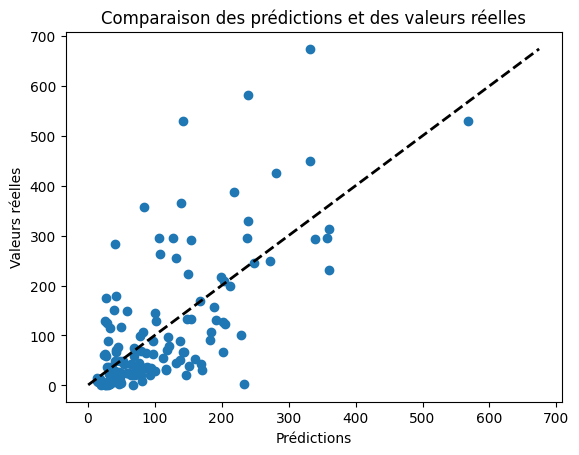

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.028539,"{'ridge__alpha': 268.26957952797216, 'scaler':..."


In [23]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Checking for alpha from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-5, 3, 15)

# Set the parameters
parameters = {"ridge__alpha" : alpha_space,
            "scaler": [scaler for _, scaler in scalers]}

grid_ridge_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_ridge_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_ridge_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_ridge_ghe, X_ghe_train, y_ghe_train)

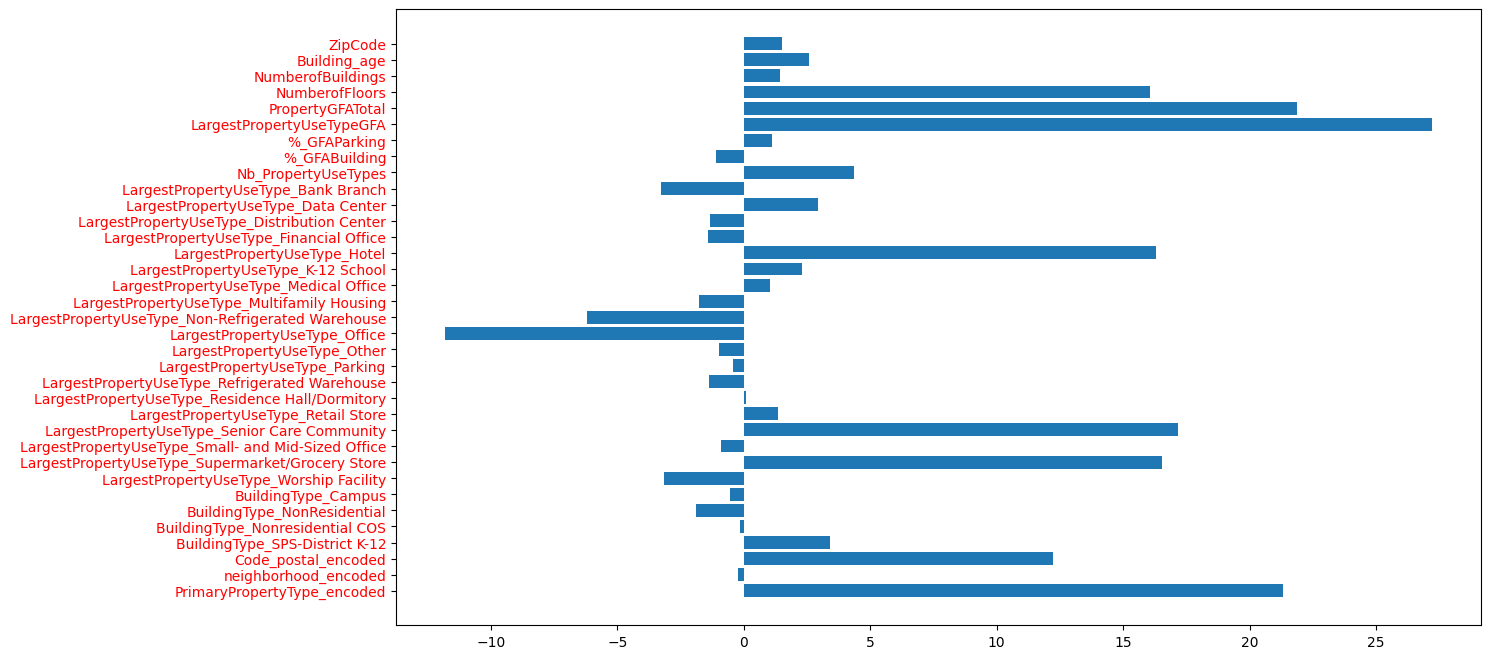

In [24]:
show_fetures_coef(grid_ridge_ghe, columns_ghe)

### Elastic Net

/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+06, tolerance: 1.411e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e+06, tolerance: 1.584e+03
  model = cd_fast.enet_coordinate_descent(
/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

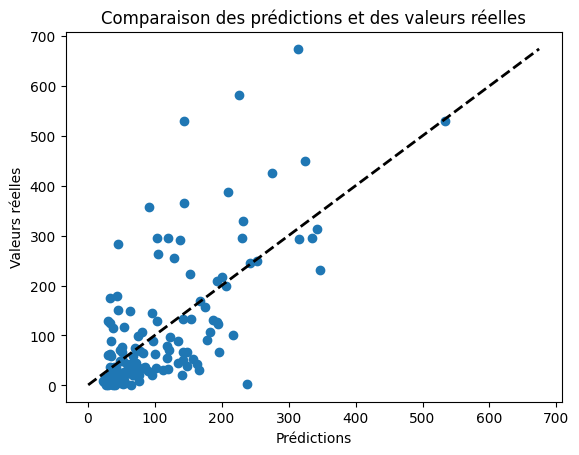

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.028539,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.085430,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."


In [25]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elnet', ElasticNet(max_iter=20000,random_state=42))
])

# Checking for alpha and l1-ratio from .0001 to 1 and finding the best value for alpha
alpha_space = np.logspace(-5, 3, 15)   
l1_space = np.logspace(-3, 0, 15)

# Set the parameters
parameters = {"elnet__alpha" : alpha_space,
            "elnet__l1_ratio" : l1_space,
            "scaler" : [scaler for _, scaler in scalers]}

grid_elnet_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_elnet_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_elnet_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_elnet_ghe, X_ghe_train, y_ghe_train)

### Decision tree Regressor

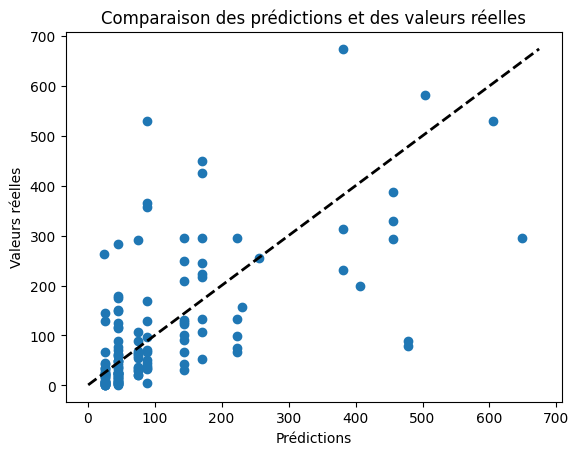

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.028539,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.085430,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.020284,"{'dectree__max_depth': 5, 'dectree__min_sample..."


In [26]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dectree', DecisionTreeRegressor(random_state=42))
])
parameters = {'dectree__min_samples_leaf': [1, 2, 3],
            'dectree__max_depth': range(5,10),
            "scaler" : [scaler for _, scaler in scalers]}

grid_dectree_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_dectree_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_dectree_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_dectree_ghe, X_ghe_train, y_ghe_train)

### RandomForest

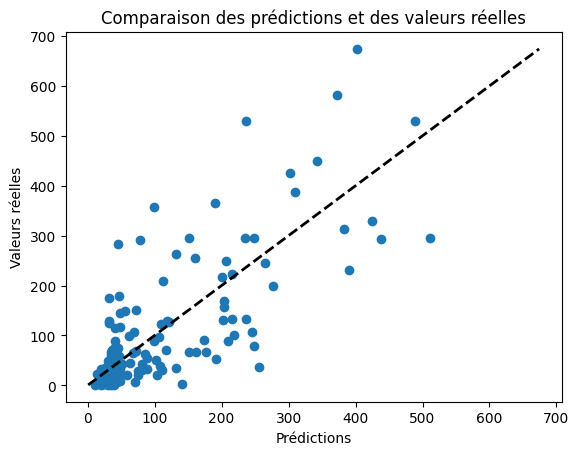

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.028539,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.085430,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.020284,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.095033,"{'randomforest__criterion': 'absolute_error', ..."
7,TotalGHGEmissions,xgboost,0.810,0.507,58.325,8361.173,0.208774,"{'scaler': MinMaxScaler(), 'xgboost__colsample..."
8,TotalGHGEmissions,randomforest_star,0.942,0.656,52.191,5828.913,1.141147,{'randomforest_star__criterion': 'absolute_err...
9,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.078379,"{'randomforest__criterion': 'absolute_error', ..."


In [60]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestRegressor(random_state=42))
])

# Set the parameters
parameters = {'randomforest__min_samples_leaf': [1, 2, 3],
            'randomforest__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'randomforest__max_features': [0.3,0.5,0.75,1,"sqrt","log2"],
            "scaler" : [scaler for _, scaler in scalers]}

grid_randomforest_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_ghe.fit(X_ghe_train, y_ghe_train.values.ravel())

metrics_df_ghe, y_pred_forest_ghe = evaluate_prediction(label_2,X_ghe_test, y_ghe_test, metrics_df_ghe, grid_randomforest_ghe, X_ghe_train, y_ghe_train)

### XGBoost

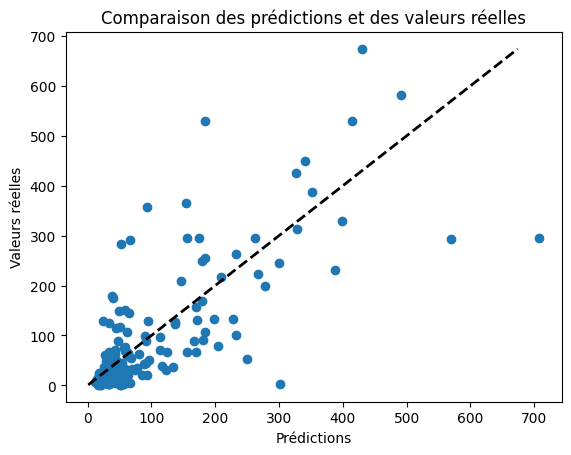

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.028539,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.085430,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.020284,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.095033,"{'randomforest__criterion': 'absolute_error', ..."
7,TotalGHGEmissions,xgboost,0.810,0.507,58.325,8361.173,0.208774,"{'scaler': MinMaxScaler(), 'xgboost__colsample..."


In [28]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', xgboost.XGBRegressor(random_state=42))
])

# Set the parameters
eta = np.logspace(-5, 0.3, 5)
L1_reg = np.logspace(-10, 10, 5)
L2_reg = np.logspace(-10, 10, 5)
parameters = {'xgboost__max_depth': [3,7,11],
            'xgboost__learning_rate': eta,
            'xgboost__reg_alpha': L1_reg,
            'xgboost__reg_lambda' : L2_reg,
            'xgboost__colsample_bytree' : [0.25,0.5,0.75,1],
            'scaler': [scaler for _, scaler in scalers]
            }

grid_xgboost_ghe = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_xgboost_ghe.fit(X_ghe_train, y_ghe_train)

metrics_df_ghe, y_pred_xgboost_ghe = evaluate_prediction(label_2, X_ghe_test, y_ghe_test, metrics_df_ghe, grid_xgboost_ghe, X_ghe_train, y_ghe_train)

# Feature importance du meilleur modèle

## Interprétation globale

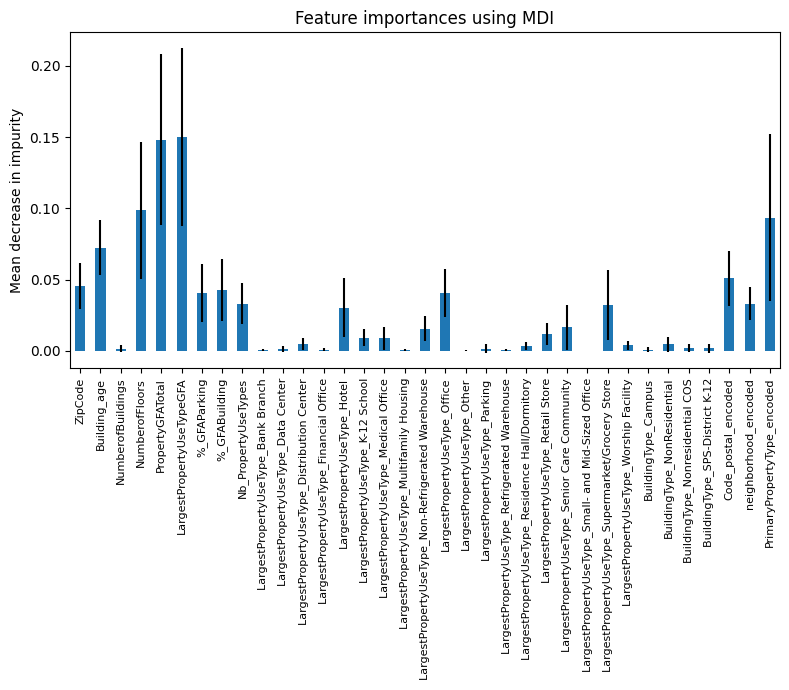

In [61]:
random_params = grid_randomforest_ghe.best_params_

scaler = random_params['scaler']
    
X_ghe_train_scaled = scaler.fit_transform(X_ghe_train)
X_ghe_test_scaled = scaler.transform(X_ghe_test)

random = RandomForestRegressor(random_state=42,
                            criterion = random_params['randomforest__criterion'],
                            max_features = random_params['randomforest__max_features'],
                            min_samples_leaf = random_params['randomforest__min_samples_leaf'])

random.fit(X_ghe_train_scaled, y_ghe_train.values.ravel())
importances = random.feature_importances_

forest_importances = pd.Series(importances, index=X_ghe_train.columns)

std = np.std([tree.feature_importances_ for tree in random.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(8,7))
forest_importances.plot.bar(yerr=std, ax=ax)

# Ajuster la taille des étiquettes de l'axe des abscisses
ax.tick_params(axis='x', labelsize=8)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Interprétation locale

In [30]:
# load JS visualization code to notebook
shap.initjs()

In [59]:
instance_test_ghe = X_ghe_test.iloc[2]

# Création de l'objet Explainer SHAP pour le modèle RandomForest
explainer_rf = shap.Explainer(random)

# Calcul des valeurs SHAP pour l'instance de données de test sélectionnée
shap_values_rf = explainer_rf.shap_values(instance_test_ghe)

# Visualisation avec shap.force_plot
shap.force_plot(explainer_rf.expected_value, shap_values_rf, instance_test_ghe)

Permutation explainer: 143it [00:55,  2.13it/s]


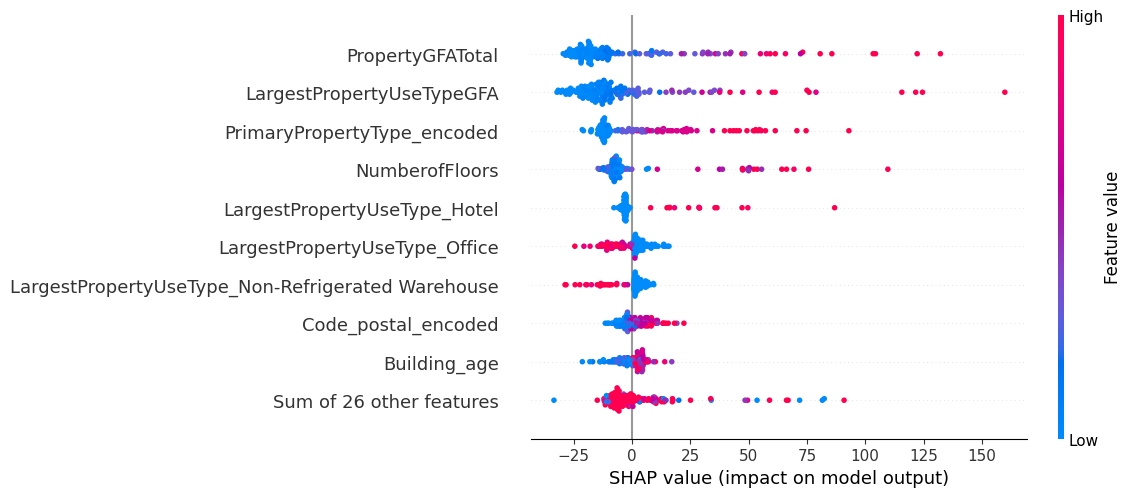

In [48]:
# Création de l'objet Explainer SHAP pour le modèle XGBoost
explainer_fr = shap.Explainer(random.predict, X_ghe_test_scaled, feature_names=X_ghe_test.columns)

# Calcul des valeurs SHAP pour l'instance de données de test sélectionnée
shap_values_rf = explainer_fr(X_ghe_test_scaled)

# Obtenir les noms des variables à partir du jeu de données
variable_names = X_ghe_test.columns

# Visualisation avec shap.plots.beeswarm
shap.plots.beeswarm(shap_values_rf)

# Test l'importance de l'energy star score

In [38]:
features_star = ['BuildingType', 'PrimaryPropertyType', 'ZipCode',
    'Neighborhood',  'Building_age','NumberofBuildings',
    'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',  '%_LargestPropertyUseType','SourceEUI(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
    'TotalGHGEmissions', "ENERGYSTARScore",
    '%_GFAParking', '%_GFABuilding','Nb_PropertyUseTypes']

df_star = data[features_star]

X_star = pipe_ohe(df_star)
y2 = df[[label_2]]

# séparer la donnée pour avoir les 
X_ghge_train_star, X_ghge_test_star, y_ghe_train_star, y_ghe_test_star = train_test_split(X_star,y2,test_size=0.15, random_state=42, stratify=df["BuildingType"])
print(X_ghge_train_star.shape, X_ghge_test_star.shape)

X_ghe_train_star, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, columns_ghe = pipe(X_ghge_train_star,col_for_mean=label_2)
X_ghe_test_star, means_zipcode_ghe, means_neighborhood_ghe, means_ppropertype_ghe, b = pipe(X_ghge_test_star, 
                                                                        means_zipcode=means_zipcode_ghe,
                                                                        means_neighborhood=means_neighborhood_ghe,
                                                                        means_ppropertype=means_ppropertype_ghe,
                                                                        col_for_mean=label_2)

(800, 41) (142, 41)
(800, 41) (142, 41)


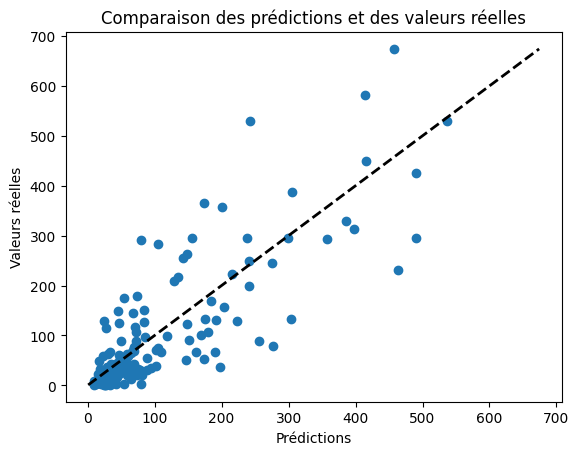

,label,modèle,r2_train,r2_test,mae,rmse,mean_fit_time,best_params
0,TotalGHGEmissions,dummy_regr,0.000,-0.000,96.138,16960.854,0.017224,"{'dummy_regr__strategy': 'mean', 'scaler': Sta..."
1,TotalGHGEmissions,reg,0.512,0.513,62.441,8254.392,0.024556,"{'reg__fit_intercept': True, 'scaler': MaxAbsS..."
2,TotalGHGEmissions,lasso,0.502,0.500,62.442,8487.587,0.021423,"{'lasso__alpha': 0.2682695795279725, 'scaler':..."
3,TotalGHGEmissions,ridge,0.496,0.490,63.278,8651.433,0.028539,"{'ridge__alpha': 268.26957952797216, 'scaler':..."
4,TotalGHGEmissions,elnet,0.483,0.485,63.403,8736.821,0.085430,"{'elnet__alpha': 1.389495494373136, 'elnet__l1..."
5,TotalGHGEmissions,dectree,0.708,0.304,67.919,11806.227,0.020284,"{'dectree__max_depth': 5, 'dectree__min_sample..."
6,TotalGHGEmissions,randomforest,0.925,0.578,58.116,7155.570,1.095033,"{'randomforest__criterion': 'absolute_error', ..."
7,TotalGHGEmissions,xgboost,0.810,0.507,58.325,8361.173,0.208774,"{'scaler': MinMaxScaler(), 'xgboost__colsample..."
8,TotalGHGEmissions,randomforest_star,0.942,0.656,52.191,5828.913,1.141147,{'randomforest_star__criterion': 'absolute_err...


In [41]:
# Créer le pipeline avec le scaler et le modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest_star', RandomForestRegressor(random_state=42))
])

# Set the parameters
parameters = {'randomforest_star__min_samples_leaf': [1, 2, 3],
            'randomforest_star__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
            'randomforest_star__max_features': [0.3,0.5,0.75,1,"sqrt","log2"],
            "scaler" : [scaler for _, scaler in scalers]}

grid_randomforest_ghe_star = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            cv=5,
                            n_jobs=-1, 
                            scoring=scoring,
                            refit="r2")
grid_randomforest_ghe_star.fit(X_ghe_train_star, y_ghe_train_star.values.ravel())

metrics_df_ghe, y_pred_random_star_ghe = evaluate_prediction(label_2, X_ghe_test_star, y_ghe_test_star, metrics_df_ghe, grid_randomforest_ghe_star, X_ghe_train_star, y_ghe_train_star)